In [1]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability
import lnPi.monoutils

#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# create a reference lnPi_phases for bulk case

In [940]:
import lnPi.serieswrapper
reload(lnPi.serieswrapper)

import lnPi.xlnPi_vec
reload(lnPi.xlnPi_vec)

reload(lnPi.segment)

pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu


# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',fill_value=np.nan,
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases_mu([None])




p = build_phases(-13.0)
p1 = build_phases(-12.0)
p.xgce.betaOmega()

/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.xlnPi_vec.xrlnPiVec'> under name 'vgce' for type <class 'lnPi.core.MaskedlnPi'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)
/Users/wpk/Documents/python/lnPi/extensions.py:344: AccessorRegistrationWarning: registration of name 'wlnPi' for type <class 'lnPi.lnpicollections.CollectionPhases'> is overriding a preexisting attribute with the same name.
  return cls._register_listaccessor(names, accessor_wrapper=_CachedListAccessorWrapper, cache_list=cache_list)
/Users/wpk/Documents/python/lnPi/extensions.py:119: AccessorRegistrationWarning: registration of accessor <class 'lnPi.segment.wlnPi'> under name 'wlnPi' for type <class 'lnPi.lnpicollections.Phases'> is overriding a preexisting attribute with the same name.
  cls._register_accessor(name, accessor, single_create)


<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -1.25806 , 384.896142])
Coordinates:
    lnz_0    float64 -13.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [941]:
PhaseCreator_s = lnPi.segment.PhaseCreator(nmax=2, 
                                           tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                           phases_factory=lnPi.serieswrapper.CollectionlnPi.from_lists,
                                            ref=ref)
build_phases_s = PhaseCreator_s.build_phases_mu([None])


In [942]:
s = build_phases_s(-13.0)
s1 = build_phases_s(-12.0)
o = lnPi.serieswrapper.CollectionlnPi.concat([s, s1], verify=True, base_class=lnPi.MaskedlnPi)

In [981]:
lnzs = np.linspace(-13, -1, 200)

In [992]:
with lnPi.set_options(tqdm_leave=True):
    o = lnPi.serieswrapper.CollectionlnPi.from_builder(lnzs, build_phases_s)

In [993]:
with lnPi.set_options(tqdm_leave=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases)

In [997]:
for phases, w in zip(o.wlnPi._phases, o.wlnPi._ws):
    break

In [1007]:
def allbut(levels, *names):
    names = set(names)
    return [item for item in levels if item not in names]

In [1008]:
allbut(o._series.index.names, 'phase')

['lnz_0']

In [1002]:
w.w_tran

array([[         inf, 461.70069158],
       [461.70069158,          inf]])

In [996]:
o.wlnPi.w_tran

lnz_0       phase  phase_nebr
-13.000000  0      0                    inf
                   1             461.700692
            1      0             461.700692
                   1                    inf
-12.939698  0      0                    inf
                                    ...    
-1.241206   1      1                    inf
-1.180905   1      1                    inf
-1.120603   1      1                    inf
-1.060302   1      1                    inf
-1.000000   1      1                    inf
Name: w_tran, Length: 317, dtype: float64

In [994]:
%%timeit -n 1 -r 1 
o.wlnPi.delta_w

472 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [995]:
%%timeit -n 1 -r 1
c.wlnPi.delta_w

931 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [988]:
%%timeit -n 1 -r 1 
o.wlnPi.w_min

319 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [989]:
%%timeit -n 1 -r 1 
c.wlnPi.w_min

821 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [990]:
%%timeit -n 1 -r 1 
o.wlnPi.w_tran

184 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [991]:
%%timeit -n 1 -r 1 
c.wlnPi.w_tran

764 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [980]:
oo.wlnPi.w_min

lnz_0       phase
-13.000000  0          17.848000
            1         405.787621
-12.939698  0          17.787699
            1         371.154053
-12.879397  0          17.727397
                        ...     
-1.241206   1       -7231.613826
-1.180905   1       -7271.412821
-1.120603   1       -7311.211816
-1.060302   1       -7351.010811
-1.000000   1       -7390.809806
Name: w_min, Length: 239, dtype: float64

In [972]:
%%timeit -n 1 -r 1
oo.wlnPi.delta_w#.to_xarray().isel(lnz_0=slice(0,10))

4.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [973]:
with lnPi.set_options(tqdm_leave=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases)

In [974]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True):
    c.wlnPi.delta_w

3.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [438]:
p = c[0]

In [448]:
c.wlnPi.from_labels

In [455]:
class wlnPiVec(object):
    def __init__(self, parent):
        self._parent = parent

    @property
    def phases(self):
        """list of phases"""
        if not hasattr(self, '_phases'):
            self._phases = []
            
            df = self._parent._series.reset_index(name='lnpi')
            for meta, g in df.groupby(df.columns.drop(['phase','lnpi']).tolist()):
                self._phases.append(g)
                
        return self._phases
    
    @property
    def ws(self):
        """list of wlnPi object"""
        if not hasattr(self, '_ws'):
            self._ws = []
            for 
        

In [490]:
w_min  = pd.DataFrame({'lnz_0':[0.0, 0.0, 1.0], 'phase':[0,1,0], 'w_min':np.random.rand(3)})
a = pd.DataFrame({'lnz_0':[0.0, 0.0, 1.0], 'phase':[0,1,0], 'x': np.random.rand(3)})
b = pd.DataFrame({'lnz_0':[0.0, 0.0, 1.0], 'phase':[0,1,0], 'x': np.random.rand(3)})

In [492]:
a.merge(b, on='lnz_0', suffixes=('','_nebr'))

,lnz_0,phase,x,phase_nebr,x_nebr
0,0.0,0,0.566247,0,0.930266
1,0.0,0,0.566247,1,0.478073
2,0.0,1,0.939849,0,0.930266
3,0.0,1,0.939849,1,0.478073
4,1.0,0,0.610420,0,0.617808


In [479]:
a = a.set_index(['lnz_0','phase'])['x']

In [500]:
for meta, g in o.groupby(['lnz_0']):
    break

In [514]:
bb = b.assign(y=1).set_index(['lnz_0','phase','x'])['y']
    

In [524]:
bb.index.droplevel(['phase','x'])

Float64Index([0.0, 0.0, 1.0], dtype='float64', name='lnz_0')

In [526]:
for meta, g in bb.groupby(bb.index.droplevel(['phase','x'])):
    break

In [481]:
b = b.rename(columns={'phase':'phase_nebr'}).set_index(['lnz_0','phase_nebr'])['x']

In [487]:
a.to_xarray() - b.to_xarray()

<xarray.DataArray 'x' (lnz_0: 2, phase: 2, phase_nebr: 2)>
array([[[ 0.596829,  0.210605],
        [ 0.296474, -0.08975 ]],

       [[ 0.506772,       nan],
        [      nan,       nan]]])
Coordinates:
  * lnz_0       (lnz_0) float64 0.0 1.0
  * phase       (phase) int64 0 1
  * phase_nebr  (phase_nebr) int64 0 1

In [469]:
w_tran

,lnz_0,phase,x
0,0.0,0,0.412522
1,0.0,1,0.415078
2,1.0,0,0.166848


In [467]:
p.wlnPi.w_tran

array([[         inf, 461.70069158],
       [461.70069158,          inf]])

In [464]:
a

,lnz_0,phase,w_min
0,0.0,0,0.230770
1,0.0,1,0.221404
2,1.0,0,0.553318


In [462]:
c.wlnPi.w_tran

array([array([[         inf, 461.70069158],
       [461.70069158,          inf]]),
       array([[         inf, 221.48157707],
       [221.48157707,          inf]]),
       array([[        inf, 91.59355321],
       [91.59355321,         inf]]),
       array([[        inf, 27.05696351],
       [27.05696351,         inf]]),
       array([[inf]]), array([[inf]]), array([[inf]]), array([[inf]]),
       array([[inf]]), array([[inf]]), array([[inf]]), array([[inf]]),
       array([[inf]]), array([[inf]]), array([[inf]]), array([[inf]]),
       array([[inf]]), array([[inf]]), array([[inf]]), array([[inf]])],
      dtype=object)

In [456]:
x = wlnPiVec(o)

In [461]:
x.phases[3]

,lnz_0,phase,lnpi
6,-11.105263,0,"[-18.06161029539, -15.953263624713307, -14.513..."
7,-11.105263,1,"[--, --, --, --, --, --, --, --, --, --, --, -..."


In [449]:
df = o._series.reset_index(name='lnpi')
for meta, g in df.groupby(df.columns.drop(['phase','lnpi']).tolist()):
    break

In [450]:
g

,lnz_0,phase,lnpi
0,-13.0,0,"[-18.06161029539, -17.84800046681857, -18.3027..."
1,-13.0,1,"[--, --, --, --, --, --, --, --, --, --, --, -..."


In [431]:
o.apply(lambda x: x.max())

lnz_0       phase
-13.000000  0         -17.848000
            1        -405.787621
-12.368421  0         -17.039547
            1         -35.797504
-11.736842  0         -15.183485
            1         347.416323
-11.105263  0         -10.960609
            1         741.422701
-10.473684  1        1144.314313
-9.842105   1        1555.383510
-9.210526   1        1971.862438
-8.578947   1        2388.704543
-7.947368   1        2805.546648
-7.315789   1        3222.388754
-6.684211   1        3639.230859
-6.052632   1        4056.072964
-5.421053   1        4472.915069
-4.789474   1        4889.757175
-4.157895   1        5306.599280
-3.526316   1        5723.441385
-2.894737   1        6140.283490
-2.263158   1        6557.125596
-1.631579   1        6973.967701
-1.000000   1        7390.809806
dtype: float64

In [411]:
g.lnpi.values

array([MaskedlnPi(
     lnz=array([-13.])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     data=masked_array(data=[-18.06161029539, -17.84800046681857,
                   -18.302704738247144, -19.13800220967572,
                   -20.23611698110429, -21.53215345253286,
                   -22.985455523961434, -24.568074095390003,
                   -26.259267066818577, -28.043793738247146,
                   -29.907977309675722, -31.841714081104293,
                   -33.837059152532866, -35.88647272396144,
                   -37.98403029539001, -40.12399686681859,
                   -42.30361943824715, -44.51712000967572,
                   -46.7615055811043, -49.03402815253286,
                   -51.33028872396144, -53.64933229539001,
                   -55.98695886681858, -58.34128643824715,
                   -60.710917009675725, -63.0928845811043,
                   -65.48499315253287, -67.88546972396145,
                   -70.29259729539001, -72.704

In [316]:
o.apply(lambda x: x.edge_distance(ref))#.rename('a').reset_index()

lnz_0       phase
-15.000000  0        661.0
-14.992996  0        661.0
-14.985993  0        661.0
-14.978989  0        661.0
-14.971986  0        661.0
                     ...  
-1.028014   1          1.0
-1.021011   1          1.0
-1.014007   1          1.0
-1.007004   1          1.0
-1.000000   1          1.0
Length: 2436, dtype: float64

In [294]:
x = np.random.rand(10, 50, 100)

In [313]:
x.argmax(0).shape

(50, 100)

In [307]:
xr.DataArray(x)

<xarray.DataArray (dim_0: 10, dim_1: 50, dim_2: 100)>
array([[[0.765569, 0.389089, ..., 0.526905, 0.071709],
        [0.550355, 0.795824, ..., 0.838561, 0.359918],
        ...,
        [0.558839, 0.65387 , ..., 0.126346, 0.223707],
        [0.174399, 0.899838, ..., 0.282832, 0.929229]],

       [[0.857451, 0.301697, ..., 0.726695, 0.842213],
        [0.446558, 0.616235, ..., 0.241773, 0.356235],
        ...,
        [0.963928, 0.700742, ..., 0.939286, 0.997221],
        [0.803996, 0.113959, ..., 0.472927, 0.052169]],

       ...,

       [[0.744152, 0.655225, ..., 0.23757 , 0.991442],
        [0.990989, 0.892694, ..., 0.130618, 0.946018],
        ...,
        [0.792166, 0.762449, ..., 0.658066, 0.383617],
        [0.800098, 0.136349, ..., 0.87173 , 0.433201]],

       [[0.65452 , 0.468809, ..., 0.040744, 0.423243],
        [0.644746, 0.698693, ..., 0.553834, 0.679632],
        ...,
        [0.081806, 0.303534, ..., 0.902986, 0.008873],
        [0.937665, 0.558451, ..., 0.065394, 0.0020

In [271]:
x[x.argmax(0)]

array([[0.99972453, 0.12636406, 0.59521565, ..., 0.82653241, 0.96384977,
        0.22437507],
       [0.76870249, 0.99634404, 0.29847943, ..., 0.99833765, 0.05431127,
        0.30129835],
       [0.26883653, 0.74458713, 0.99676196, ..., 0.89385399, 0.98397511,
        0.5069612 ],
       ...,
       [0.76870249, 0.99634404, 0.29847943, ..., 0.99833765, 0.05431127,
        0.30129835],
       [0.86386758, 0.28915255, 0.07334557, ..., 0.0857455 , 0.99916806,
        0.75445144],
       [0.27700681, 0.64820121, 0.1815117 , ..., 0.25710824, 0.51222945,
        0.99085147]])

In [266]:
np.where(x == x.max())

(array([26]), array([0]))

In [ ]:
xr.Da

In [264]:
o.vgce.lnpi.argmax('n_0')

<xarray.DataArray 'lnpi' (sample: 2436)>
array([  0,   0,   0, ..., 660, 660, 660])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp     float64 0.7
    volume   int64 729

In [254]:
np.unravel_index(7264, shape=x.shape)

(72, 64)

In [252]:
x.argmax()

7264

In [245]:
o.vgce.argmax()

array([[  0],
       [  0],
       [  0],
       ...,
       [660],
       [660],
       [660]])

In [244]:
(
    o.iloc[:].apply(lambda x: x.xgce.dens)
    .pipe(lambda x: xr.concat(x.values, 'sample').drop('lnz_0').assign_coords(**{'sample':x.index}))
    
)

<xarray.DataArray 'dens' (sample: 2436, component: 1)>
array([[2.308293e-04],
       [2.324585e-04],
       [2.340993e-04],
       ...,
       [9.053496e-01],
       [9.053496e-01],
       [9.053496e-01]])
Coordinates:
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [154]:
a=o.vgce.edge_distance(ref).unstack()#.plot(hue='phase')

b=c.xgce.edge_distance(ref).swap_dims({'rec':'lnz_0'})#.plot(hue='phase')

In [162]:
c.xgce.max()

array([ -18.0616103 ,  -18.0616103 ,  -18.0616103 , ..., 7381.56518392,
       7386.18749507, 7390.80980623])

In [169]:
o.vgce.lnpi.max('n_0')

<xarray.DataArray 'lnpi' (sample: 2436)>
array([ -18.06161 ,  -18.06161 ,  -18.06161 , ..., 7381.565184, 7386.187495,
       7390.809806])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp     float64 0.7
    volume   int64 729

In [159]:
c[:10].xgce.argmax()

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

<xarray.DataArray 'edge_distance' ()>
array(0.)
Coordinates:
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429

In [95]:
o.iloc[300].local_argmax()

(557,)

In [103]:
o.vgce.coords_state['lnz_0']

<xarray.DataArray 'lnz_0' (sample: 2436)>
array([-15.      , -14.992996, -14.985993, ...,  -1.014007,  -1.007004,
        -1.      ])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp     float64 0.7
    volume   int64 729

In [136]:
xr.DataArray([x.edge_distance(ref) for x in o], dims=o.vgce.dims_rec, coords=o.vgce._rec_coords)

<xarray.DataArray (sample: 2436)>
array([661., 661., 661., ...,   1.,   1.,   1.])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429

In [113]:
o.vgce.pi_norm.argmax('n_0')

<xarray.DataArray 'lnpi' (sample: 2436)>
array([  0,   0,   0, ..., 660, 660, 660])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -15.0 -14.99 -14.99 -14.98 ... -1.014 -1.007 -1.0
  - phase    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp     float64 0.7
    volume   int64 729

In [106]:
o.iloc[300].local_argmax()

(557,)

In [99]:
c[300:400].xgce.edge_distance(ref)

<xarray.DataArray 'edge_distance' (rec: 100, phase: 2)>
array([[660.,  83.],
       [660.,  83.],
       [660.,  83.],
       [660.,  82.],
       [660.,  82.],
       [660.,  82.],
       [660.,  82.],
       [660.,  82.],
       [660.,  82.],
       [660.,  81.],
       [660.,  81.],
       [660.,  80.],
       [660.,  79.],
       [660.,  79.],
       [660.,  79.],
       [660.,  79.],
       [660.,  79.],
       [660.,  79.],
       [660.,  78.],
       [660.,  78.],
       [660.,  78.],
       [660.,  77.],
       [660.,  77.],
       [660.,  77.],
       [660.,  76.],
       [660.,  76.],
       [660.,  76.],
       [660.,  76.],
       [660.,  76.],
       [660.,  76.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  74.],
       [660.,  73.],
       [660.,  72.],
       [660.,  72.],
       [660.,  72.],
       [660.,  72.],
       [660.,  72.],
       [660.,  72.],

In [92]:
[x.local_argmax() for x in o]

[(0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),
 (0,),

In [85]:
o.vgce._parent.iloc[0]

MaskedlnPi(
     lnz=array([-15.])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     data=masked_array(data=[-18.06161029539, -19.84800046681857,
                   -22.302704738247144, -25.13800220967572,
                   -28.23611698110429, -31.53215345253286,
                   -34.985455523961434, -38.56807409539,
                   -42.25926706681858, -46.043793738247146,
                   -49.90797730967572, -53.84171408110429,
                   -57.837059152532866, -61.88647272396144,
                   -65.98403029539, -70.12399686681859,
                   -74.30361943824715, -78.51712000967572,
                   -82.7615055811043, -87.03402815253287,
                   -91.33028872396144, -95.64933229539001,
                   -99.98695886681858, -104.34128643824715,
                   -108.71091700967573, -113.0928845811043,
                   -117.48499315253287, -121.88546972396145,
                   -126.29259729539001, -130.7044528668186,

In [363]:
o.vgce.edge_distance(ref).unstack()

<xarray.DataArray 'edge_distance' (lnz_0: 20, phase: 2)>
array([[660.,  88.],
       [659.,  64.],
       [657.,  46.],
       [651.,  30.],
       [ nan,  16.],
       [ nan,   5.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.],
       [ nan,   1.]])
Coordinates:
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * lnz_0    (lnz_0) float64 -13.0 -12.37 -11.74 -11.11 ... -2.263 -1.632 -1.0
  * phase    (phase) int64 0 1
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    dims_rec:    ['sample']
    long_name:   distance from upper edge

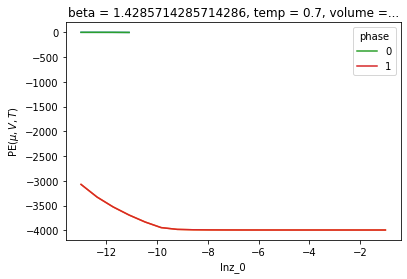

In [365]:
c.xgce.PE.swap_dims({'rec':'lnz_0'}).plot(hue='phase')

o.vgce.PE.unstack().plot(hue='phase')

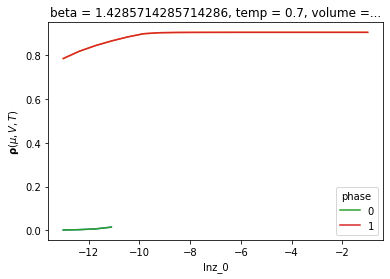

In [366]:
#%%timeit -n 1 -r 1
c.xgce.dens.swap_dims({'rec':'lnz_0'}).plot(hue='phase')

#%%timeit -n 1 -r 1
o.vgce.dens.unstack('sample').plot(hue='phase')

In [367]:
da = o.to_dataarray()

In [376]:
labels = []
lnzs = []
for i, g in da.groupby('sample'):
    lnzs.append(np.array([g.coords[k] for k in da.attrs['dims_lnz']]))

    labels.append(g.values)
    
    

In [380]:
for label, lnz in zip(labels, lnzs):
    break

In [386]:
items = []
indexes = []

features=None
include_boundary=None

for label, lnz in zip(labels, lnzs):
    lnpi = ref.reweight(lnz)

    masks, features_tmp = lnPi.serieswrapper.labels_to_masks(labels=label, features=features, include_boundary=False, 
                                                             convention=False, check_features=True)

    index = list(np.array(features_tmp) - 1)
    items += lnpi.list_from_masks(masks, convention=False)
    indexes += index


In [368]:
lnPi.serieswrapper.CollectionlnPi.from_dataarray(ref, da)

AssertionError: 

In [278]:
labels, lnzs = lnPi.serieswrapper.CollectionlnPi.from_dataarray(ref, da)

indexes, items = lnPi.serieswrapper.CollectionlnPi.from_labels(ref, labels, lnzs)

In [282]:
lnPi.serieswrapper.CollectionlnPi.from_lists(items, indexes).vgce.dens

<xarray.DataArray 'dens' (sample: 4, component: 1)>
array([[0.001754],
       [0.785685],
       [0.005069],
       [0.834477]])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0 -12.0 -12.0
  - phase    (sample) int64 0 1 0 1
    temp     float64 0.7
    volume   int64 729
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    dims_rec:    ['sample']
    long_name:   ${\bf \rho}(\mu,V,T)$

In [64]:
da = o.to_dataarray()

In [65]:
da

<xarray.DataArray 'labels' (sample: 2, n_0: 661)>
array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0
    temp     float64 0.7
    volume   int64 729
Dimensions without coordinates: n_0

In [43]:
for i, g in da.groupby('sample'):
    break

In [49]:
for i, g in da.reset_index('sample').groupby('sample'):
    break

In [ ]:
p.vgce._st

In [57]:
p.xgce.lnpi

<xarray.DataArray 'lnpi' (phase: 2, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194]])
Coordinates:
    lnz_0    float64 -13.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [55]:
o.vgce.lnpi

<xarray.DataArray 'lnpi' (sample: 4, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194],
       [ -18.06161 ,  -16.848   ,  -16.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,  135.408046,  133.119866,
         130.809806]])
Coordinates:
    beta     float64 1.429
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0 -12.0 -12.0
  - phase    (sample) int64 0 1 0 1
    temp     float64 0.7
    volume   int64 729
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']
    dims_rec:    ['sample']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [53]:
p.to_dataarray()

<xarray.DataArray 'labels' (n_0: 661)>
array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)
Coordinates:
    lnz_0    float64 -13.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [376]:
p.to_dataarray()

<xarray.DataArray 'labels' (n_0: 661)>
array([1, 1, 1, ..., 2, 2, 2], dtype=uint8)
Coordinates:
    lnz_0    float64 -13.0
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [ ]:
o.iloc[0]

In [391]:
ref.state_kws

{'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}

In [389]:
o.iloc[0].state_kws == o.iloc[1].state_kws

True

In [386]:
ref.state_kws

{'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}

In [385]:
{'a':1, **{'b':2}}

{'a': 1, 'b': 2}

In [384]:
o.index

MultiIndex([(-13.0, 0, 729, 0.7, 1.4285714285714286),
            (-13.0, 1, 729, 0.7, 1.4285714285714286),
            (-12.0, 0, 729, 0.7, 1.4285714285714286),
            (-12.0, 1, 729, 0.7, 1.4285714285714286)],
           names=['lnz_0', 'phase', 'volume', 'temp', 'beta'])

In [382]:
ref._index_dict()

{'lnz_0': -12.308571428571428,
 'volume': 729,
 'temp': 0.7,
 'beta': 1.4285714285714286}

In [380]:
o.index

MultiIndex([(-13.0, 0, 729, 0.7, 1.4285714285714286),
            (-13.0, 1, 729, 0.7, 1.4285714285714286),
            (-12.0, 0, 729, 0.7, 1.4285714285714286),
            (-12.0, 1, 729, 0.7, 1.4285714285714286)],
           names=['lnz_0', 'phase', 'volume', 'temp', 'beta'])

In [379]:
ref._index_dict(0)

{'lnz_0': -12.308571428571428,
 'phase': 0,
 'volume': 729,
 'temp': 0.7,
 'beta': 1.4285714285714286}

In [377]:
p.xgce._standard_attrs

array([{'dims_n': ['n_0'], 'dims_lnz': ['lnz_0'], 'dims_comp': ['component'], 'dims_state': ['lnz_0', 'volume', 'temp', 'beta']},
       {'dims_n': ['n_0'], 'dims_lnz': ['lnz_0'], 'dims_comp': ['component'], 'dims_state': ['lnz_0', 'volume', 'temp', 'beta']}],
      dtype=object)

In [375]:
o.labels()

<xarray.DataArray 'labels' (sample: 2, n_0: 661)>
array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=int8)
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0
  - volume   (sample) float64 729.0 729.0
  - temp     (sample) float64 0.7 0.7
  - beta     (sample) float64 1.429 1.429
Dimensions without coordinates: n_0

In [123]:
g = o.groupby(o.index.droplevel('phase').names)

In [221]:
df = o.series.reset_index(name='lnpi')

In [224]:
for meta, g in df.groupby(df.columns.drop(['phase','lnpi']).tolist()):
    break

In [248]:
pd.DataFrame([g.drop(['phase','lnpi'], axis=1).iloc[0]])


,lnz_0,volume,temp,beta
0,-13.0,729.0,0.7,1.428571


In [240]:
pd.DataFrame([gg for gg in g.drop(['phase','lnpi'], axis=1)])

,0
0,lnz_0
1,volume
2,temp
3,beta


In [235]:
g.iloc[:1].drop(['phase','lnpi'], axis=1)

,lnz_0,volume,temp,beta
0,-13.0,729,0.7,1.428571


In [200]:
for meta, g in o.groupby(o.index.droplevel('phase').names):
    break

In [220]:
g.iloc[0]

MaskedlnPi(
     lnz=array([-13.])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     data=masked_array(data=[-18.06161029539, -17.84800046681857,
                   -18.302704738247144, -19.13800220967572,
                   -20.23611698110429, -21.53215345253286,
                   -22.985455523961434, -24.568074095390003,
                   -26.259267066818577, -28.043793738247146,
                   -29.907977309675722, -31.841714081104293,
                   -33.837059152532866, -35.88647272396144,
                   -37.98403029539001, -40.12399686681859,
                   -42.30361943824715, -44.51712000967572,
                   -46.7615055811043, -49.03402815253286,
                   -51.33028872396144, -53.64933229539001,
                   -55.98695886681858, -58.34128643824715,
                   -60.710917009675725, -63.0928845811043,
                   -65.48499315253287, -67.88546972396145,
                   -70.29259729539001, -72.7044528668

In [202]:
for phase, gg in g.groupby('phase'):
    break

In [210]:
for m, gg in g.items():
    break

In [215]:
g.reset_index(name='lnpi')

,lnz_0,phase,volume,temp,beta,lnpi
0,-13.0,0,729,0.7,1.428571,"[-18.06161029539, -17.84800046681857, -18.3027..."
1,-13.0,1,729,0.7,1.428571,"[--, --, --, --, --, --, --, --, --, --, --, -..."


In [206]:
gg.iloc[0].mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [176]:
gg.iloc[0]

MaskedlnPi(
     lnz=array([-13.])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     data=masked_array(data=[-18.06161029539, -17.84800046681857,
                   -18.302704738247144, -19.13800220967572,
                   -20.23611698110429, -21.53215345253286,
                   -22.985455523961434, -24.568074095390003,
                   -26.259267066818577, -28.043793738247146,
                   -29.907977309675722, -31.841714081104293,
                   -33.837059152532866, -35.88647272396144,
                   -37.98403029539001, -40.12399686681859,
                   -42.30361943824715, -44.51712000967572,
                   -46.7615055811043, -49.03402815253286,
                   -51.33028872396144, -53.64933229539001,
                   -55.98695886681858, -58.34128643824715,
                   -60.710917009675725, -63.0928845811043,
                   -65.48499315253287, -67.88546972396145,
                   -70.29259729539001, -72.7044528668

In [161]:
for i, gg in g.series.iterrows():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-161-04d362607bf0>, line 1)

In [ ]:
ref.list_from_masks()

In [152]:
g.vgce.lnpi.isnull()

<xarray.DataArray 'lnpi' (sample: 2, n_0: 661)>
array([[False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0
  - phase    (sample) int64 0 1
  - volume   (sample) int64 729 729
  - temp     (sample) float64 0.7 0.7
  - beta     (sample) float64 1.429 1.429
Dimensions without coordinates: n_0

In [141]:
for i, g in o.vgce.lnpi.groupby('sample'):
    break

<xarray.DataArray 'lnpi' (sample: 4, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194],
       [ -18.06161 ,  -16.848   ,  -16.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,  135.408046,  133.119866,
         130.809806]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0 -12.0 -12.0
  - phase    (sample) int64 0 1 0 1
  - volume   (sample) int64 729 729 729 729
  - temp     (sample) float64 0.7 0.7 0.7 0.7
  - beta     (sample) float64 1.429 1.429 1.429 1.429
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']
    dims_rec:    ['sample']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [140]:
o.vgce.lnpi.reset_index('sample')

<xarray.DataArray 'lnpi' (sample: 4, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194],
       [ -18.06161 ,  -16.848   ,  -16.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ...,  135.408046,  133.119866,
         130.809806]])
Coordinates:
    lnz_0    (sample) float64 -13.0 -13.0 -12.0 -12.0
    phase    (sample) int64 0 1 0 1
    volume   (sample) int64 729 729 729 729
    temp     (sample) float64 0.7 0.7 0.7 0.7
    beta     (sample) float64 1.429 1.429 1.429 1.429
Dimensions without coordinates: sample, n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']
    dims_rec:    ['sample']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [218]:
x = lnPi.xlnPi_vec.xrlnPiVec(s)

In [195]:
x._lnpi_0

<xarray.DataArray (sample: 2)>
array([-18.06161, -18.06161])
Dimensions without coordinates: sample

In [185]:
xr.DataArray(np.array(1), dims=[])

<xarray.DataArray ()>
array(1)

In [181]:
x.lnz()

<xarray.DataArray 'lnz' (sample: 2, component: 1)>
array([[-13.],
       [-13.]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0
  - phase    (sample) int64 0 1
  - volume   (sample) int64 729 729
  - temp     (sample) float64 0.7 0.7
  - beta     (sample) float64 1.429 1.429
Dimensions without coordinates: component
Attributes:
    long_name:  $\ln\beta{\bf\mu}$

In [172]:
s.index.name = None

In [173]:
s.index

MultiIndex([(-13.0, 0, 729, 0.7, 1.4285714285714286),
            (-13.0, 1, 729, 0.7, 1.4285714285714286)],
           names=['lnz_0', 'phase', 'volume', 'temp', 'beta'])

In [174]:
x.lnpi.assign_coords(sample=s.index)

<xarray.DataArray 'lnpi' (sample: 2, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194]])
Coordinates:
  * sample   (sample) MultiIndex
  - lnz_0    (sample) float64 -13.0 -13.0
  - phase    (sample) int64 0 1
  - volume   (sample) int64 729 729
  - temp     (sample) float64 0.7 0.7
  - beta     (sample) float64 1.429 1.429
Dimensions without coordinates: n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [166]:
x.betamu

<xarray.DataArray 'betamu' (sample: 2, component: 1)>
array([[-13.],
       [-13.]])
Dimensions without coordinates: sample, component
Attributes:
    long_name:  $\beta {\bf \mu}$

In [158]:
x._wrapper.dims_rec

['sample']

In [159]:
x._wrapper.wrap_lnpi(s._lnpi_tot)

<xarray.DataArray (sample: 2, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194]])
Dimensions without coordinates: sample, n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']

In [161]:
x.lnpi

<xarray.DataArray 'lnpi' (sample: 2, n_0: 661)>
array([[ -18.06161 ,  -17.848   ,  -18.302705, ...,         nan,         nan,
                nan],
       [        nan,         nan,         nan, ..., -522.591954, -525.880134,
        -529.190194]])
Dimensions without coordinates: sample, n_0
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0']
    long_name:   $\ln \Pi(n,\mu,V,T)$

In [116]:
np.stack([x.lnz for x in s])

array([[-13.],
       [-13.]])

In [114]:
len(s.s)

2

In [85]:
d = ref._index_dict()

In [87]:
d.values()

dict_values([-12.308571428571428, 729, 0.7, 1.4285714285714286])

In [94]:
a = pd.MultiIndex.from_frame(pd.DataFrame([d]))

In [106]:
a.append

MultiIndex([(-12.308571428571428, 729, 0.7, 1.4285714285714286)],
           names=['lnz_0', 'volume', 'temp', 'beta'])

In [82]:
pd.MultiIndex(ref._index_dict(0))

TypeError: Must pass both levels and codes

In [58]:
for x in s:
    pass

In [25]:
s = build_phases(-13.0, phases_factory=lnPi.serieswrapper.CollectionlnPi.from_lists)

In [10]:
lnPi.serieswrapper.CollectionlnPi.register_listaccessor('xgce')

In [38]:
o = lnPi.serieswrapper.CollectionlnPi(data=[ref] * 4, index=pd.MultiIndex.from_tuples([(0, 0), (1,0), (1,1), (2,1)], names=['a','b']), concat_dim='sample')

## create a collection

In [5]:
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
import joblib
set_loky_pickler('pickle')

In [16]:
lnzs = np.linspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 2000)

In [17]:
#%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_use=True, tqdm_leave=True, joblib_use=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases=build_phases, concat_coords='different', 
                                       unstack=True, set_index=['lnz_0','phase'], clean_coords=True )

In [18]:
%%timeit -n 1 -r 1 
index = (
    pd.DataFrame([dict(x.state_kws, lnz_0=x.lnz[0]) for x in c.flat], index=c.flat._multiindex)
    .reset_index()
)
index = pd.MultiIndex.from_frame(index)
#index
o = (
    xr.DataArray(np.stack([x.view(np.ma.MaskedArray) for x in c.flat]), dims=['sample','n_0'])
    .assign_coords(sample=index)
)

pi = np.exp(o - o.max('n_0'))
pi_norm = pi / pi.sum(ref.xgce.dims_n)
nvec = (pi_norm * ref.xgce.ncoords).sum(ref.xgce.dims_n).values

204 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True):
    c.xgce.nvec


2.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
c.spinodals(2, build_phases, inplace=True, append=True)
c.binodals(2, build_phases, inplace=True, append=True)
spin = c.spinodals.access
bino = c.binodals.access

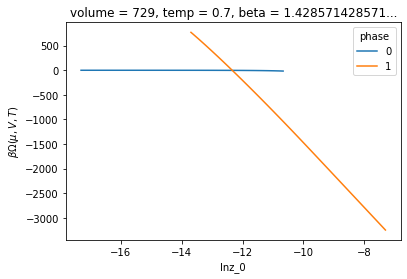

In [13]:
c.xgce_prop.betaOmega().unstack().plot(hue='phase')

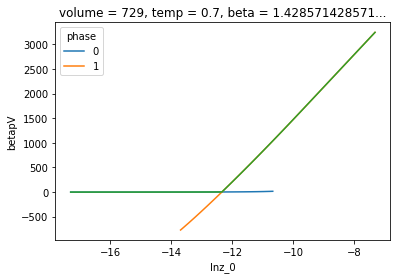

In [14]:
c.xgce_prop.table(dim_to_suffix='component', mask_stable=False).betapV.unstack().plot(hue='phase')
c.xgce_prop.table(dim_to_suffix='component', mask_stable=True).betapV.unstack().plot(hue='phase')

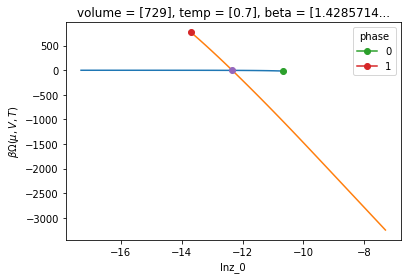

In [15]:
c.xgce.betaOmega().plot(hue='phase')
(
    spin.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .plot(hue='phase', marker='o')
)

bino.xgce.betaOmega().sel(phase=0).plot.line(marker='o', label='binodal')




In [29]:
# mu min/max

In [35]:
reload(lnPi.monoutils)

<module 'lnPi.monoutils' from '/Users/wpk/Documents/python/lnPi/monoutils.py'>

In [54]:
c_course, c = lnPi.monoutils.limited_collection(build_phases, lnz_range=np.round(ref.lnz + [-10, +10], 1), dlnz=0.1, 
                                                rho_min=0.0001, edge_distance_min=8, 
                                                collection_kws={'unstack':True,'set_index':['lnz_0','phase']})

In [55]:
c.spinodals(2, build_phases, inplace=True, append=True)
c.binodals(2, build_phases, inplace=True, append=True)

In [56]:
c.sort_by_lnz()

In [57]:
table = c.xgce_prop.table(['dens','pressure'], mask_stable=True, dim_to_suffix='component')

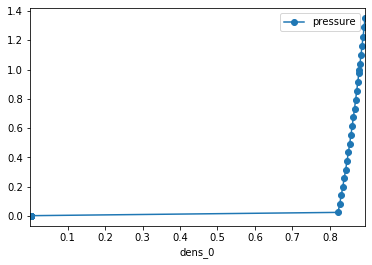

In [58]:
table.to_dataframe().plot('dens_0','pressure', marker='o')

In [59]:
import xarray as xr
@xr.register_dataarray_accessor('lwhere')
def lwhere(da):
    def where(condition, drop=False):
        return da.where(condition(da), drop=drop)
    return where

In [60]:
# test saving

In [61]:
da = (
    c.to_dataarray()
    .pipe(c.spinodals.assign_coords)
    .pipe(c.binodals.assign_coords)
    .sortby('lnz_0')
    .reset_index('rec', drop=True)
)

In [62]:
c2 = lnPi.CollectionPhases.from_dataarray(ref, da, unstack=True, set_index=['lnz_0','phase'])
c2.spinodals.from_dataarray(da)
c2.binodals.from_dataarray(da)

In [63]:
c.binodals.access.xgce_prop.table()

<xarray.Dataset>
Dimensions:  (component: 1, lnz_0: 1, phase: 2)
Coordinates:
    volume   (lnz_0) int64 729
    temp     (lnz_0) float64 0.7
    beta     (lnz_0) float64 1.429
    rec      (lnz_0) int64 0
  * lnz_0    (lnz_0) float64 -12.34
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    nvec     (component, lnz_0, phase) float64 2.558 597.9
    betapV   (lnz_0, phase) float64 2.475 2.475
    PE_n     (lnz_0, phase) float64 -0.04095 -5.578

In [64]:
c2.binodals.access.xgce_prop.table()#.swap_dims({'rec':'lnz_0'})

<xarray.Dataset>
Dimensions:  (component: 1, lnz_0: 1, phase: 2)
Coordinates:
    volume   (lnz_0) int64 729
    temp     (lnz_0) float64 0.7
    beta     (lnz_0) float64 1.429
    rec      (lnz_0) int64 0
  * lnz_0    (lnz_0) float64 -12.34
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    nvec     (component, lnz_0, phase) float64 2.558 597.9
    betapV   (lnz_0, phase) float64 2.475 2.475
    PE_n     (lnz_0, phase) float64 -0.04095 -5.578

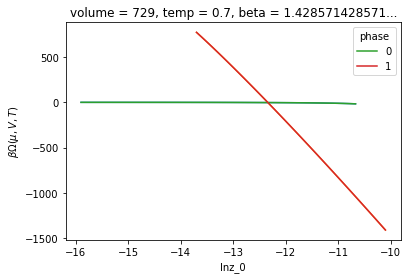

In [65]:
c.xgce.betaOmega().plot(hue='phase')
c2.xgce.betaOmega().plot(hue='phase')

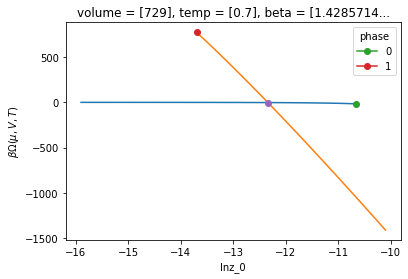

In [67]:
c.xgce.betaOmega().plot(hue='phase')

(
    c.spinodals.access.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

# bulk 065

In [75]:
reload(lnPi.monoutils)

<module 'lnPi.monoutils' from '/Users/wpk/Documents/python/lnPi/monoutils.py'>

In [132]:
beta = 1.0 / 0.65

In [133]:
ref_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', lnz=-4.453015418106743E+00 /0.65,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))
phase_creator_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_bulk, 
                                         merge_kws=dict(efac=0.5), tag_phases=tag_phases2)
build_phases_bulk = phase_creator_bulk.build_phases_mu([None])

In [145]:
c_course_bulk, c_bulk = lnPi.monoutils.limited_collection(build_phases_bulk, 
                                                np.round(ref_bulk.lnz + [-10, +10], 1), 0.05, edge_distance_min=8,
                                                         collection_kws=dict(set_index=['lnz_0','phase']))

In [146]:
c_course_bulk.spinodals(2, build_phases_bulk, inplace=True)
c_course_bulk.binodals(2, build_phases_bulk, inplace=True)

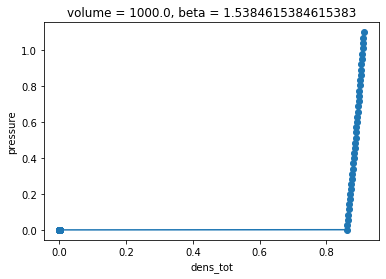

In [151]:
(
    c_bulk.xgce_prop.table(['dens_tot','pressure'], mask_stable=True)
    #.swap_dims({'rec':'lnz_0'})
     .swap_dims({'lnz_0':'dens_tot'})
     .pressure.plot(marker='o')
    
)

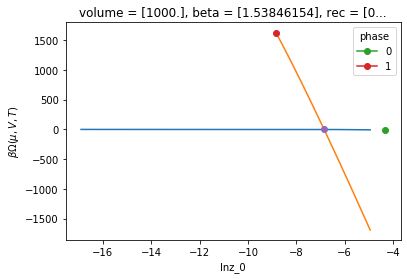

In [154]:
c_bulk.xgce.betaOmega().plot(hue='phase')

(
    c_course_bulk.spinodals.access.xgce.betaOmega()
    
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c_course_bulk.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

# confined

In [155]:
ref_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',
                                       lnz=-0.500000E+01/0.65,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phase_creator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=ref_conf, 
                                              merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

In [156]:
build_phases_conf = phase_creator_conf.build_phases_mu([None])

In [172]:
c_course_bulk.binodals.access.lnz[0,0]

-6.8518860562331465

In [246]:
lnzs_conf = np.geomspace(np.log(1e-7), c_course_bulk.binodals.access.lnz[0,0], 200)
c_conf = lnPi.CollectionPhases.from_builder(lnzs_conf, build_phases_conf, set_index=['lnz_0','phase'])

In [247]:
c_conf.xgce.edge_distance(ref_conf).min('phase').min()

<xarray.DataArray 'edge_distance' ()>
array(286.)
Coordinates:
    volume   float64 7e+03
    beta     float64 1.538

In [248]:
c_conf.spinodals(2, build_phases_conf, inplace=True, append=True)
c_conf.binodals(2, build_phases_conf, inplace=True, append=True)

In [249]:
c_conf.sort_by_lnz()

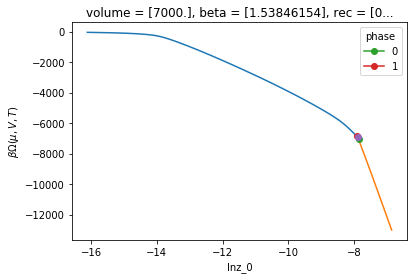

In [250]:
c_conf.xgce.betaOmega().plot(hue='phase')

(
    c_conf.spinodals.access.xgce.betaOmega()
    
    .pipe(lambda x: x.where(x.phase == x.rec))

    .plot(hue='phase', marker='o')
)

c_conf.binodals.access.xgce.betaOmega().sel(phase=0).plot.line(marker='o')

In [187]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


# make isotherm

In [251]:
# new bulk on same spacinf
c_bulk = lnPi.CollectionPhases.from_builder(c_conf.lnz[:,0], build_phases_bulk, set_index=['lnz_0','phase'])

In [252]:
lnz_spin = c_conf.spinodals.access.lnz[:,0]

In [253]:
psat = c_course_bulk.binodals.access.xgce_prop.pressure().values.flatten()[0]

In [254]:
table_bulk = (
    c_bulk.xgce_prop.table(['pressure'], mask_stable=True)
    .assign(pscaled=lambda x: x.pressure / psat)
    .drop('volume')
)

In [255]:
table_conf = (
    c_conf.xgce_prop.table(['ntot'])
    .drop('volume')
)

In [276]:
isotherm = (
    xr.merge((table_bulk.pscaled, table_conf.ntot))
    .set_coords('pscaled')
    .ntot
)
isotherm

<xarray.DataArray 'ntot' (lnz_0: 203, phase: 2)>
array([[  29.625822,         nan],
       [  31.081696,         nan],
       [  32.640422,         nan],
       ...,
       [        nan, 6004.87468 ],
       [        nan, 6008.203599],
       [        nan, 6012.530636]])
Coordinates:
    beta     float64 1.538
    rec      (lnz_0) float64 0.0 1.0 2.0 3.0 4.0 ... 199.0 200.0 201.0 202.0
  * lnz_0    (lnz_0) float64 -16.12 -16.05 -15.98 ... -6.911 -6.881 -6.852
    pscaled  (lnz_0) float64 9.347e-05 0.0001002 0.0001073 ... 0.9419 0.9706 1.0
  * phase    (phase) int64 0 1
Attributes:
    standard_name:  total_particles
    long_name:      $n(\mu,V,T)$

(0, 1.0)

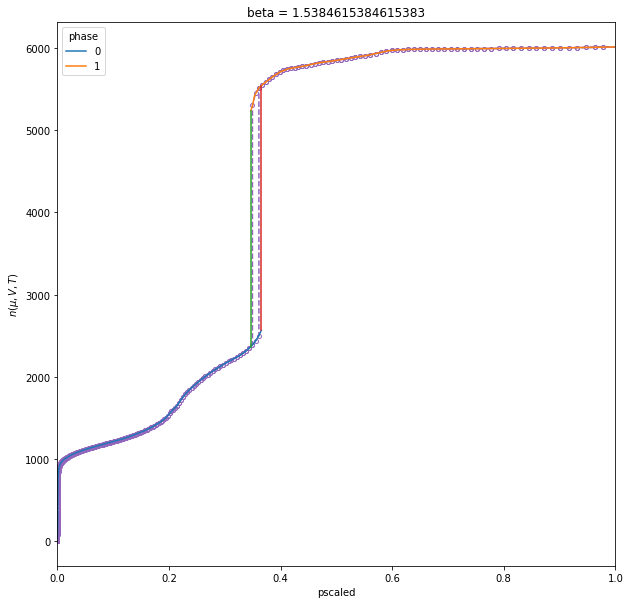

In [261]:
fig,ax = plt.subplots(figsize=(10,10))

isotherm.swap_dims({'lnz_0':'pscaled'}).plot(hue='phase')

for meta, g in isotherm.sel(lnz_0=lnz_spin).to_dataframe().reset_index().groupby('lnz_0'):
    plt.plot(g['pscaled'],g['ntot'])
    
plt.plot(df.pscaled,df.rho, marker='o',mfc='None', ls='--',zorder=-1, ms=4)
plt.gca().set_xlim(0,1.0)